In [3]:
# !brew install libomp
# !pip install lightgbm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import scipy
from mlxtend.plotting import plot_decision_regions

import warnings # 実行に関係ない警告を無視
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, f1_score
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import lightgbm as lgbm

import shap

# import sys
# sys.path.append('../')
# from preprocessings.preprocessing import clean_text, normalize, set_stopwords, extract

# # データフレームを綺麗に出力する関数
# import IPython
# def display(*dfs, head=True):
#     for df in dfs:
#         IPython.display.display(df.head() if head else df)

In [32]:
# data_250words = pd.read_csv('../data/vec_250words.csv')
# data_100words = pd.read_csv('../data/vec_100words.csv')
data_250nochar = pd.read_csv('../data/vec_250words_nochar.csv')
data_100nochar = pd.read_csv('../data/vec_100words_nochar.csv')
# data_250words = data_250words.drop('Unnamed: 0', axis=1)
# data_100words = data_100words.drop('Unnamed: 0', axis=1)
data_250nochar = data_250nochar.drop('Unnamed: 0', axis=1)
data_100nochar = data_100nochar.drop('Unnamed: 0', axis=1)
data = pd.read_csv('../data/vec250.csv')
data = data.drop('Unnamed: 0', axis=1)

In [6]:
# data_250words

In [7]:
# group = data_250words.groupby('author').mean()
# group
# # sns.pairplot(data_250words, hue='author_num')

In [8]:
# data_250words.groupby('author').size() 

In [9]:
# title = data_250words.title
# # num_1 = data_250words.query('author_num==1')
# data_250words = data_250words.set_index(title)
# data_250T = data_250words.sort_values('author').T
# data_250T = data_250T[:-1]
# data_250T
# # .sort_values(by=title[0], ascending=False)
# # num_1
# # tenchi_1
# # tenchi_1 = tenchi_1.sort_valu

In [10]:
# data_100words

In [11]:
# # 行列を転置
# # title = data_250words.title

# data_250words = data_250words.set_index(title)
# data_250T = data_250words.sort_values('author').T
# data_250T = data_250T[:-1]
# data_250T
# # data_250T = data_250T.sort_values(by='title', ascending=False)

# # # # data_T
# # # # 値で降順ソート
# # data_T = data_T.sort_values(by='' ,ascending=False)
# # # # # 上位10語を取得
# # data_T.head(100)

In [ ]:
df1 = data_250nochar
y = df1.author_num.values
X = df1.drop(['author_num', 'author', 'title'], axis=1).values
feature_names = df1[:-3].columns
feature_names = feature_names[:-3]

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, y_train.shape

((3015, 250), (3015,))

In [32]:
# y_train.value_counts(), y_test.value_counts()

In [33]:
# df_lgb = lgbm.LGBMClassifier()
# df_lgb.fit(X_train, y_train)

In [34]:
# lgbm = lgbm.LGBMClassifier(max_depth=10,
#                           n_estimators=1000)

In [44]:
## データ用意
#条件設定
max_score = 0
SearchMethod = 0
SVC_grid = {SVC(): {"C": [10 ** i for i in range(-3, 4)],
                    "gamma": [10 ** i for i in range(-3, 4)],
                    "decision_function_shape": ["ovo",'ovr']
                   }}
SVC_random = {SVC(): {"C": scipy.stats.uniform(0.001, 100),
                    "gamma": scipy.stats.uniform(0.001, 100),
                    "decision_function_shape": ["ovo",'ovr']
                     }}

#トレーニングデータ、テストデータの分離
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

#グリッドサーチ
for model, param in SVC_grid.items():
    clf = GridSearchCV(model, param)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = f1_score(y_test, y_pred, average="micro")

    if max_score < score:
        max_score = score
        best_param = clf.best_params_
        best_model = model.__class__.__name__

#ランダムサーチ
for model, param in SVC_random.items():
    clf =RandomizedSearchCV(model, param)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = f1_score(y_test, y_pred, average="micro")

    if max_score < score:
        SearchMethod = 1
        max_score = score
        best_param = clf.best_params_
        best_model = model.__class__.__name__

if SearchMethod == 0:
    print("サーチ方法:グリッドサーチ")
else:
    print("サーチ方法:ランダムサーチ")
print("ベストスコア:{}".format(max_score))
print("モデル:{}".format(best_model))
print("パラメーター:{}".format(best_param))

#ハイパーパラメータを調整しない場合との比較
model = SVC()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("")
print("デフォルトスコア:", score)

(3015, 250) (3015,)
(1293, 250) (1293,)
サーチ方法:グリッドサーチ
ベストスコア:0.8453209590100541
モデル:SVC
パラメーター:{'C': 10, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'kernel': 'rbf'}

デフォルトスコア: 0.8360402165506574


In [68]:
svm = SVC(
        C=10,
        gamma=0.1,
        decision_function_shape="ovo",
        random_state=0
        )
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test) # テストデーテへの予測実行
print(svm.score(X_train, y_train))
print(metrics.accuracy_score(y_test, y_pred))
print(y_pred, y_test)


0.9466003316749585
0.8437741686001546
[1 9 7 ... 3 1 8] [1 9 7 ... 3 1 8]


In [69]:
y_pred = svm.predict(X_test) # テストデーテへの予測実行
print(svm.score(X_train, y_train))
print(metrics.accuracy_score(y_test, y_pred))
print(y_pred, y_test)

0.9466003316749585
0.8437741686001546
[1 9 7 ... 3 1 8] [1 9 7 ... 3 1 8]


In [45]:
# ?svm

In [70]:
shap.initjs()

In [ ]:
explainer = shap.Explainer(model = svm.predict, 
                           masker = X_train,
                           feature_names = feature_names)
shap_values = explainer(X_test)

Permutation explainer:  20%|█▉        | 258/1293 [43:37<2:28:07,  8.59s/it]

In [ ]:
feature_names

In [4]:
df2 = data_100nochar
y = df2.author_num.values
X = df2.drop(['author_num', 'author', 'title'], axis=1).values
feature_names = df2[:-3].columns
feature_names = feature_names[:-3]
feature_names

Index(['あたり', 'あつた', 'あと', 'いくら', 'いま', 'うち', 'こと', 'すべて', 'そう', 'ため', 'つた',
       'つて', 'つもり', 'とき', 'ところ', 'なか', 'なし', 'なつ', 'ひと', 'ひとり', 'ほか', 'まま',
       'みんな', 'もの', 'もん', 'やつ', 'わけ', '一人', '一緒', '三十', '不思議', '世界', '主人',
       '主義', '事実', '二人', '二十', '人物', '人間', '今度', '今日', '仕事', '以上', '伸子', '作品',
       '作家', '作者', '俳優', '先生', '同時', '問題', '場合', '婦人', '子供', '学校', '実際', '小説',
       '当時', '必要', '意味', '感じ', '感情', '戦争', '手紙', '文化', '文学', '新聞', '日本', '映画',
       '時代', '時間', '本当', '東京', '様子', '次第', '歴史', '気持', '演劇', '現実', '生活', '相手',
       '研究', '社会', '科学', '精神', '素子', '結婚', '自分', '自然', '自由', '自身', '舞台', '芸術',
       '言葉', '調子', '通り', '運動', '部屋', '関係', '青年'],
      dtype='object')

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3446, 100) (3446,)
(862, 100) (862,)


In [6]:
## データ用意
#条件設定
max_score = 0
SearchMethod = 0
SVC_grid = {SVC(): {"C": [10 ** i for i in range(-3, 4)],
                    "gamma": [10 ** i for i in range(-3, 4)],
                    "decision_function_shape": ["ovo",'ovr']
                   }}
SVC_random = {SVC(): {"C": scipy.stats.uniform(0.001, 100),
                    "gamma": scipy.stats.uniform(0.001, 100),
                    "decision_function_shape": ["ovo",'ovr']
                     }}

#トレーニングデータ、テストデータの分離
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

#グリッドサーチ
for model, param in SVC_grid.items():
    clf = GridSearchCV(model, param)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = f1_score(y_test, y_pred, average="micro")

    if max_score < score:
        max_score = score
        best_param = clf.best_params_
        best_model = model.__class__.__name__

#ランダムサーチ
for model, param in SVC_random.items():
    clf =RandomizedSearchCV(model, param)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = f1_score(y_test, y_pred, average="micro")

    if max_score < score:
        SearchMethod = 1
        max_score = score
        best_param = clf.best_params_
        best_model = model.__class__.__name__

if SearchMethod == 0:
    print("サーチ方法:グリッドサーチ")
else:
    print("サーチ方法:ランダムサーチ")
print("ベストスコア:{}".format(max_score))
print("モデル:{}".format(best_model))
print("パラメーター:{}".format(best_param))

#ハイパーパラメータを調整しない場合との比較
model = SVC()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("")
print("デフォルトスコア:", score)

(3015, 100) (3015,)
(1293, 100) (1293,)
サーチ方法:グリッドサーチ
ベストスコア:0.805877803557618
モデル:SVC
パラメーター:{'C': 10, 'decision_function_shape': 'ovo', 'gamma': 1}

デフォルトスコア: 0.8035576179427688


In [29]:
svm = SVC(
        C=100,
        gamma=0.09,
        decision_function_shape="ovo",
        )
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test) # テストデーテへの予測実行
print(svm.score(X_train, y_train))
print(metrics.accuracy_score(y_test, y_pred))
print(y_pred, y_test)


0.9570516540917006
0.8051044083526682
[ 1  9  7  6  8  2  3  2  9  3  3  6  8  9  3  2  3 10  4  7  1  7  7  3
  1  3  3  3  1  3  6  8  6  7  5  3  9  5  8  5  6  6  2  6  3  4 10  6
 10  3  3  1  6  5  1  3  7  9  7  3  9  6  5  1  8  5  9  8  3  3 10  3
  1  7  3  1  6  6  3  3  7  3  6  7  3  9  3  3 10  2  6  8  6  3  3  8
  6  8  9  3 10  3  6  2 10 10  7  7  8  7  3  3  6  2  7  3  6  8  3  1
  6  1  1  8  3  7  9  9  6  7 10  6  1  1  4  4  3  9  5  7  1  1  8  3
 10 10  1  3  8  6  2  2  3  2  2  8  3  9  1  5  3  6  1  1  5  3  7  7
  3  5  3  7  1  6  7  4  3  9  3  4  3  4 10  3  7  1  8  6  3  3  1  1
  2  3  6  3  4  3  6  4  3  3  7  7 10  5  3  4  1  8  3  7  9  2  8  6
  5  3  7  3  3  4  8 10  3  3  3  4  5  6  6  9  9  1  3  1  9  6  1  7
  5  6  3  3 10  3  3  2  3  3  5  7  3  6  6  6  6  3  3  1  8  1 10  3
  3  3  3  3 10  3  8  1  3  1  3  3  9  1 10  9  5  3  3  6  9  8  1  9
  1  8  4  3  3  3  6  5  3  3  9  3  9  9  1  4  7  7  3  3  1  7  9  6
  9  3  3  9 

In [8]:
shap.initjs()

In [30]:
explainer = shap.Explainer(model = svm.predict, 
                           masker = X_train,
                           feature_names = feature_names)
shap_values = explainer(X_test)

Permutation explainer: 863it [2:18:39,  9.66s/it]                           


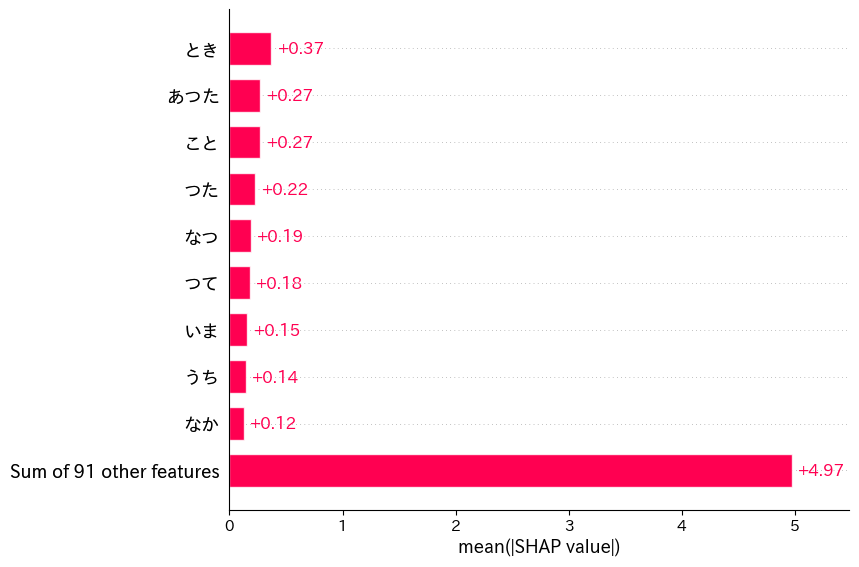

In [31]:
shap.plots.bar(shap_values)

In [33]:
data

,いくら,からだ,こと,じい,せい,そば,ただ,つた,つて,つもり,...,風,首,馬,髪,魂,鳥,鼻,author_num,author,title
0,0.000000,0.0,0.319771,0.0,0.016944,0.000000,0.000000,0.080532,0.138947,0.000000,...,0.024101,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,1,坂口安吾,FARCE に就て
1,0.000000,0.0,0.142490,0.0,0.000000,0.000000,0.000000,0.396497,0.017846,0.000000,...,0.030955,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,1,坂口安吾,Pierre Philosophale
2,0.101211,0.0,0.146731,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,1,坂口安吾,“歌笑”文化
3,0.000000,0.0,0.468089,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.057439,0.000000,0.0,0.0000,0.000000,0.000000,1,坂口安吾,“能筆ジム”
4,0.000000,0.0,0.104891,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,1,坂口安吾,「信長」作者のことば
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4303,0.037538,0.0,0.126983,0.0,0.000000,0.093269,0.000000,0.037310,0.038624,0.112442,...,0.033498,0.000000,0.912651,0.0,0.0495,0.000000,0.000000,10,豊島与志雄,鬼カゲさま
4304,0.060164,0.0,0.261671,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0000,0.039571,0.000000,10,豊島与志雄,魔法探し
4305,0.000000,0.0,0.564876,0.0,0.000000,0.000000,0.109952,0.000000,0.000000,0.097260,...,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,10,豊島与志雄,鯉
4306,0.000000,0.0,0.430562,0.0,0.000000,0.029915,0.081543,0.000000,0.000000,0.072130,...,0.021488,0.081393,0.000000,0.0,0.0000,0.000000,0.028585,10,豊島与志雄,鳶と柿と鶏


In [64]:
df3 = data
y = df3.author_num.values
X = df3.drop(['author_num', 'author', 'title'], axis=1).values
feature_names = df3[:-3].columns
feature_names = feature_names[:-3]

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, y_train.shape

((3015, 250), (3015,))

In [66]:
# ## データ用意
# #条件設定
# max_score = 0
# SearchMethod = 0
# SVC_grid = {SVC(): {"C": [10 ** i for i in range(-4, 5)],
#                     "gamma": [10 ** i for i in range(-4, 5)],
#                     "decision_function_shape": ["ovo",'ovr']
#                    }}
# SVC_random = {SVC(): {"C": scipy.stats.uniform(0.0001, 1000),
#                     "gamma": scipy.stats.uniform(0.0001, 1000),
#                     "decision_function_shape": ["ovo",'ovr']
#                      }}

# #トレーニングデータ、テストデータの分離
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

# #グリッドサーチ
# for model, param in SVC_grid.items():
#     clf = GridSearchCV(model, param)
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     score = f1_score(y_test, y_pred, average="micro")
#     print(score)
#     if max_score < score:
#         max_score = score
#         best_param = clf.best_params_
#         best_model = model.__class__.__name__
#         print(max_score)

# #ランダムサーチ
# for model, param in SVC_random.items():
#     clf =RandomizedSearchCV(model, param)
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     score = f1_score(y_test, y_pred, average="micro")
#     print(score)
#     if max_score < score:
#         SearchMethod = 1
#         max_score = score
#         best_param = clf.best_params_
#         best_model = model.__class__.__name__
#         print(max_score)
# if SearchMethod == 0:
#     print("サーチ方法:グリッドサーチ")
# else:
#     print("サーチ方法:ランダムサーチ")
# print("ベストスコア:{}".format(max_score))
# print("モデル:{}".format(best_model))
# print("パラメーター:{}".format(best_param))

# #ハイパーパラメータを調整しない場合との比較
# model = SVC()
# model.fit(X_train, y_train)
# score = model.score(X_test, y_test)
# print("")
# print("デフォルトスコア:", score)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

svm = SVC(C=120, gamma=0.0095, decision_function_shape="ovo")               # インスタンス生成
svm.fit(X_train, y_train) # SVM実行

y_pred = svm.predict(X_test) # テストデーテへの予測実行
print(svm.score(X_train, y_train))
print(metrics.accuracy_score(y_test, y_pred))
print(y_pred, y_test)

0.9276948590381426
0.8128383604021655
[3 6 4 ... 9 6 3] [3 6 4 ... 9 6 3]


In [68]:
shap.initjs()

In [73]:
explainer = shap.explainers.Permutation(model = svm.predict, 
                            masker = X_train,
                            feature_names = feature_names,
                            max_evals = 501)
shap_values = explainer(X_test)

Permutation explainer: 1294it [4:44:32, 13.21s/it]                            


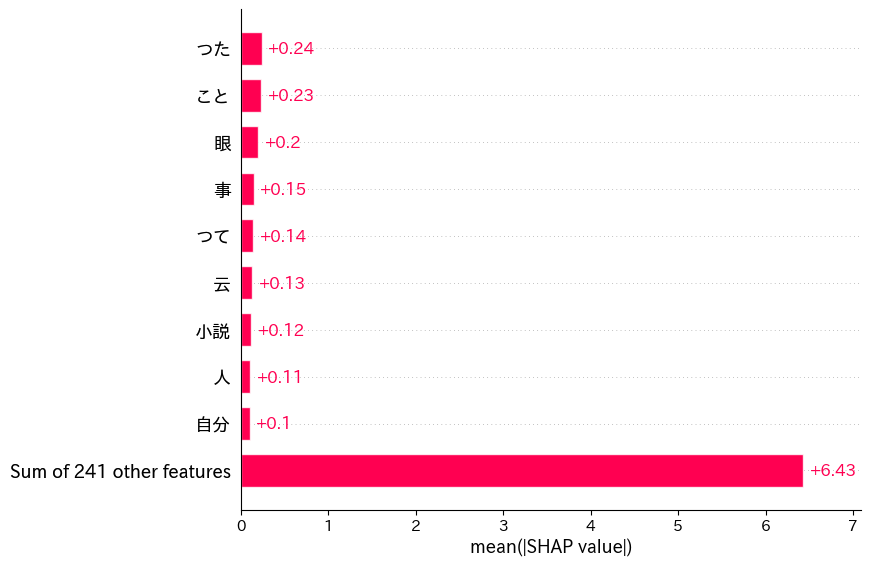

In [74]:
shap.plots.bar(shap_values)

In [93]:
shap_values

.values =
array([[ 0.   ,  0.   , -0.265, ..., -0.07 ,  0.   ,  0.   ],
       [ 0.015,  0.   , -0.02 , ..., -0.1  ,  0.   ,  0.   ],
       [ 0.   , -0.03 , -0.33 , ..., -0.04 ,  0.   , -0.02 ],
       ...,
       [ 0.   ,  0.01 ,  0.17 , ...,  0.   , -0.01 ,  0.015],
       [ 0.   ,  0.02 ,  0.08 , ..., -0.04 ,  0.04 ,  0.   ],
       [ 0.   , -0.01 , -0.105, ...,  0.02 ,  0.   ,  0.04 ]])

.base_values =
array([4.68, 4.68, 4.68, ..., 4.68, 4.68, 4.68])

.data =
array([[0.        , 0.        , 0.10993527, ..., 0.        , 0.        ,
        0.        ],
       [0.03406496, 0.        , 0.32923937, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.00399397, ..., 0.01089845, 0.        ,
        0.02943283],
       [0.        , 0.        , 0.52736629, ..., 0.        , 0.04485957,
        0.        ],
       [0.02958481, 0.07826617, 0.15726619, ..., 

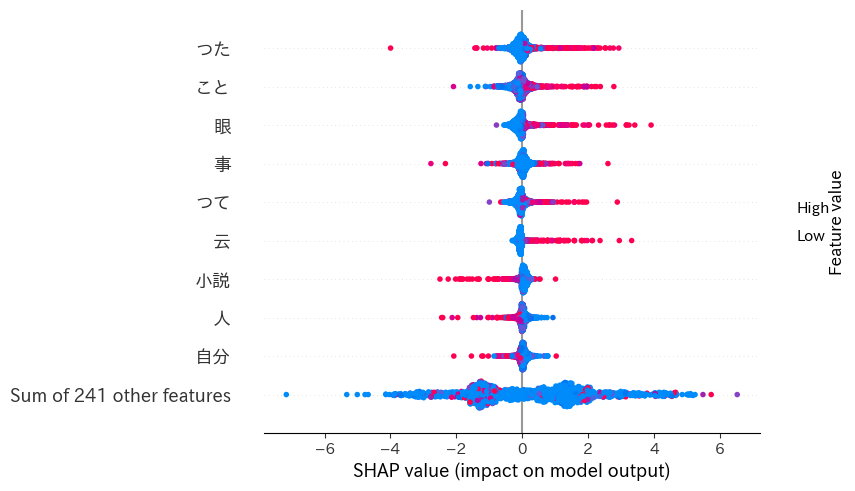

In [78]:
shap.plots.beeswarm(shap_values)

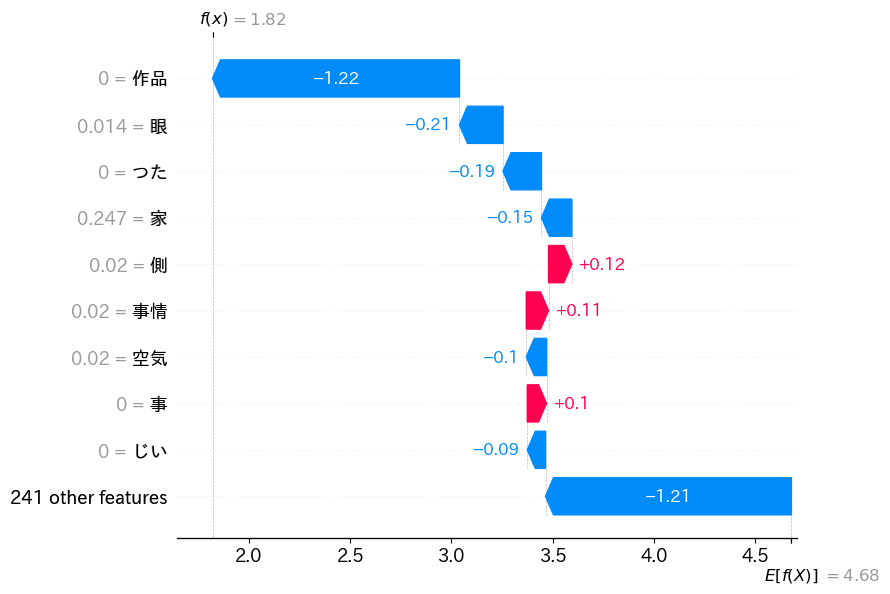

In [95]:
shap.plots.waterfall(shap_values[251])

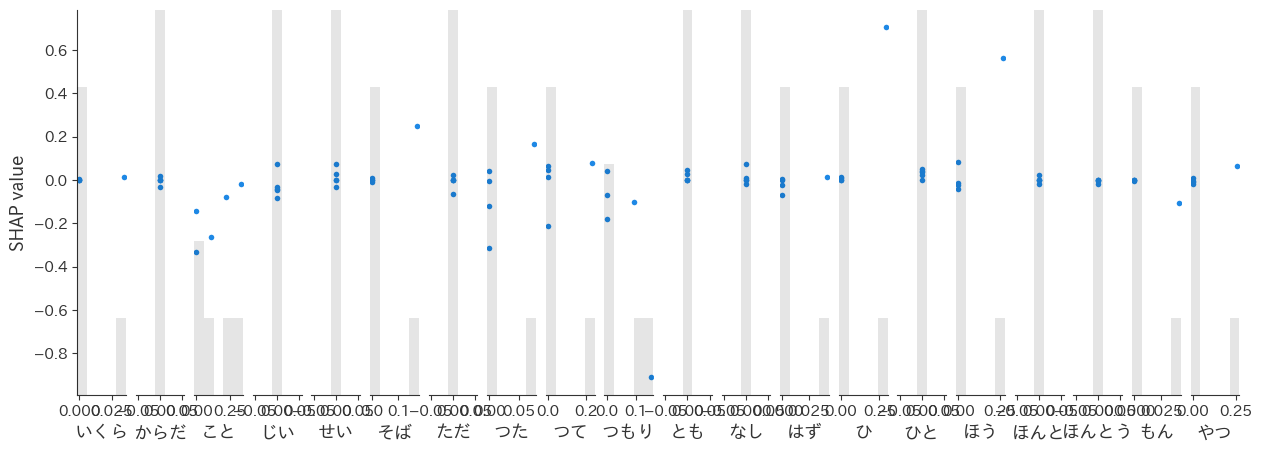

In [105]:
shap.plots.scatter(shap_values[:5,:20], color=shap_values[:5,:20])

In [106]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0:1000,:], X_test_display.iloc[0:1000,:],link="logit")

AttributeError: 'Permutation' object has no attribute 'expected_value'

In [108]:
shap.explainer

Init signature:
shap.explainers.Permutation(
    model,
    masker,
    link=CPUDispatcher(<function identity at 0x7fd932824a60>),
    feature_names=None,
    linearize_link=True,
    **call_args,
)
Docstring:     
This method approximates the Shapley values by iterating through permutations of the inputs.

This is a model agnostic explainer that gurantees local accuracy (additivity) by iterating completely
through an entire permutatation of the features in both forward and reverse directions (antithetic sampling).
If we do this once, then we get the exact SHAP values for models with up to second order interaction effects.
We can iterate this many times over many random permutations to get better SHAP value estimates for models
with higher order interactions. This sequential ordering formulation also allows for easy reuse of
model evaluations and the ability to effciently avoid evaluating the model when the background values
for a feature are the same as the current input value. We can

In [117]:
explainer2 = shap.Explainer(model = svm.predict, 
                            masker = X_train,
                            feature_names = feature_names,
                            max_evals = 501
                            )
shap_values = explainer(X_test)

Permutation explainer:  35%|███▌      | 457/1293 [1:46:42<3:16:04, 14.07s/it]


KeyboardInterrupt: 

In [114]:
shap.Explainer

Help on package shap.explainers in shap:

NAME
    shap.explainers

PACKAGE CONTENTS
    _additive
    _deep (package)
    _exact
    _explainer
    _gpu_tree
    _gradient
    _kernel
    _linear
    _partition
    _permutation
    _sampling
    _tree
    mimic
    other (package)
    pytree
    tf_utils

FILE
    /opt/anaconda3/lib/python3.8/site-packages/shap/explainers/__init__.py




In [7]:
# !pip install MeCab-python3

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import scipy
from mlxtend.plotting import plot_decision_regions

import warnings # 実行に関係ない警告を無視
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, f1_score
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import lightgbm as lgbm

import shap

In [14]:
data = pd.read_csv('../data/vec250.csv')

In [15]:
data_dict=dict(row_data)

In [16]:
y = data.author_num
X = data.drop(['author_num', 'author', 'title'], axis=1)
feature_names = data[:-3].columns
feature_names = feature_names[:-3]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=0)

In [ ]:
clf = lgbm.LGBMClassifier(
    objective='multiclass',
    n_estimators=1000,
    early_stopping_rounds=50, 
    num_class=10,
    # num_leaves=10, #
    max_depth=2, #
    learning_rate=0.01,
    importance_type='gain',
    # random_state=42
)
clf.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=100)